## Lecture 15

#### Announcements
* P3 due! P4 out! P2 grading is (slowly) happening!

#### Goals
* Discuss several different ways 3D reconstructions can be represented
* Explain why positional encodings are necessary for MLP neural networks in contexts like fitting 2D images or 3D scene representations.
* Be prepared to implement NeRF (Project 4).
  * Know how to perform volume rendering along camera rays to predict a pixel color from the model

#### 3D Representations

* SfM: given images, get camera pose and (**sparse**) 3D scene geometry
  * Large-scale SfM result examples:
    * Ladybug: http://swehrwein.github.io/sfmflex-vis/Ladybug_demo.html
    * Venice: https://facultyweb.cs.wwu.edu/~wehrwes/sfmflex-vis/Venice_demo.html
* Multiview stereo / 3D reconstruction: given SfM outputs, recover 3D model of the world
  * https://www.youtube.com/watch?v=5ceiOd8Yx3g&t=25s
  * https://earth.google.com/web/@47.62102506,-122.3493987,55.50286284a,993.8487854d,35y,18.72359613h,64.09030499t,360r/data=OgMKATA
* Interesting question: how do you represent your 3D model?


##### Brainstorm

How would you reconstruct a 3D model of the world, given images, camera poses, and a sparse point cloud of the world?

How would you even *represent* a 3D model of the world?

These questions are clearly interrelated. Let's Brainstorm.
* Polygon mesh (+textures)
* Point cloud
* Shape dictionary
    * Trees, cars, buildings
    * Planes
* Voxels
* Continuous volume + density


In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

# codebase imports
import util
import filtering
import features
import geometry
import ML

#### 3D Representations - Some ideas

Source for some relevant visuals: https://courses.cs.washington.edu/courses/cse455/10wi/lectures/multiview.pdf

* Depth maps; multi-camera: depth map fusion
* Voxel grids
* Point clouds
* Patch clouds (surfels)
* Polygon mesh
* SDF
* Neural network!?

#### ML review: 0 to MLP

Review by example the anatomy, care, and feeding of an MLP


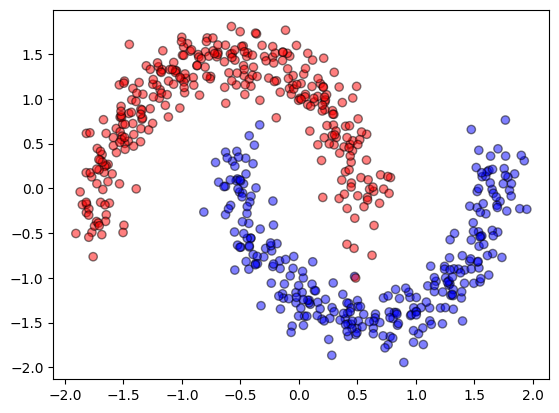

In [2]:
import sklearn
import sklearn.datasets

moons = ML.scale_split(sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=0))
X, Xva, y, yva, xx, yy = moons
ML.plot_dataset(X, y)

**Code tour**:
* look at `ML.MLP()`
* look at training routine below
* flag me down if something's not familiar!

In [3]:
def train(model, X, y, train_iters=1000):
    optimizer = torch.optim.Adam(model.parameters())

    for i in range(train_iters):
        optimizer.zero_grad()
    
        batch_indices = torch.randint(0, X.shape[0], (1000,))
        
        batch_X, batch_y = X[batch_indices,:], y[batch_indices]
        outputs = model(batch_X).squeeze()
        loss = F.mse_loss(batch_y, outputs)
        loss.backward()
        optimizer.step()
    return model

def plot_trained_model(model, X, y, xx, yy, encode=lambda x: x):

    with torch.no_grad():     
        h, w = xx.shape
        dense_X = encode(torch.vstack([xx.flatten(), yy.flatten()]).T)
        dense_ypred = model(dense_X).reshape((h, w)).flip([0])
        plt.gca().imshow(dense_ypred, extent=[xx.min(), xx.max(), yy.min(),yy.max()])
        ML.plot_dataset(X, y)


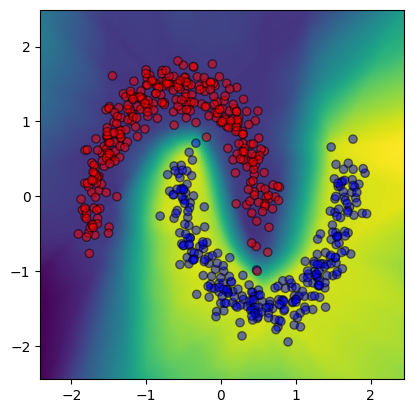

In [4]:
model = ML.MLP(2)
model = train(model, X, y, train_iters=1000)

plot_trained_model(model, X, y, xx, yy)

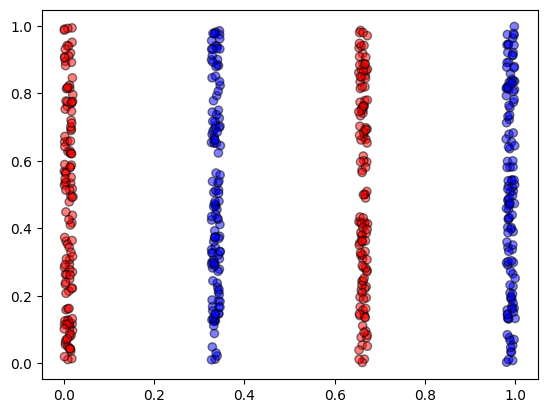

In [13]:
X, y = ML.make_stripes(500, 4, 0.01)
ML.plot_dataset(X, y)

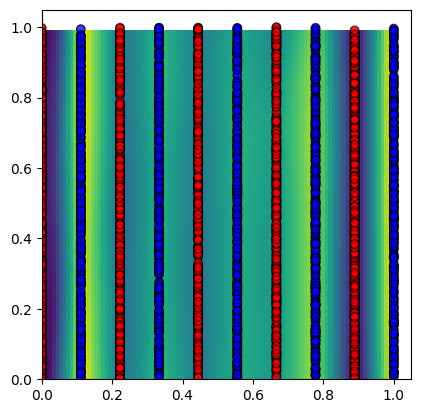

In [19]:
X, y = ML.make_stripes(500, 10, 0.00)
xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
xx = torch.Tensor(xx)
yy = torch.Tensor(yy)
model = train(ML.MLP(2), X, y)

plot_trained_model(model, X, y, xx, yy)


**Conclusion**: high-frequency stuff is hard for the MLP to learn!

**Question**: We need to go deeper; will more layers fix this?

Try MLP_N

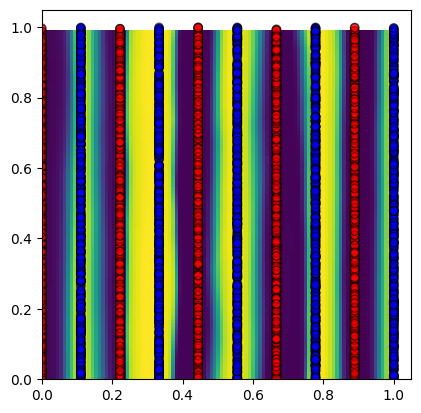

In [28]:
X, y = ML.make_stripes(5000, 10, 0.0)
xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
xx = torch.Tensor(xx)
yy = torch.Tensor(yy)
model = train(ML.MLP_N(2, 12, 128), X, y, 2000)

plot_trained_model(model, X, y, xx, yy)


To a point, but it's going to get expensive...

Alternative: "positional encoding"

Very handwavy intuition: "smear" the input signal across more input channels to allow the network to learn high-frequency stuff.

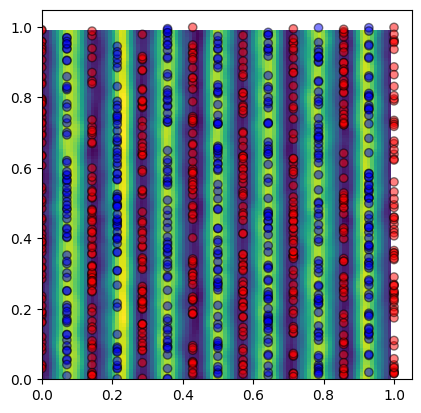

In [31]:
pi = torch.pi

X, y = ML.make_stripes(1000, 15, 0.0)


# very barebones positional encoding:
def positional_encoding(X):
    return torch.hstack([
        torch.sin(2*pi * X),
        torch.sin(4*pi * X),
        torch.sin(8*pi * X),
        torch.sin(16*pi * X),
        torch.cos(2*pi * X),
        torch.cos(4*pi * X),
        torch.cos(8*pi * X),
        torch.cos(16*pi * X)])

Xpe = positional_encoding(X)

model = train(ML.MLP(Xpe.shape[1]), Xpe, y)

plot_trained_model(model, X, y, xx, yy, encode=positional_encoding)


#### Neural Radiance Fields

Paper with helpful visuals: https://arxiv.org/pdf/2003.08934.pdf

##### Representation: continuous volume with color and density

* Basic idea: Parameterize a volumetric representation with an MLP

![](../data/nerf_overview.png)

Color and density is a function of 3D location and view direction $f(x, y, z, \phi, \theta) = (r, g, b, \sigma)$
  * Detail: density is constrained to depend only on location, not direction.

##### MLP Architecture:
![](../data/nerf_arch.png)


##### Volume Rendering

Given a magic color-density-producing machine, how do you make an image?

(notes)

##### HW Problem 2
The somewhat obfusque equation for weighting samples along a volume rendering ray is:
$$
C(𝐫)=\int_{t_n}^{t_f}T(t)\sigma(𝐫(t))𝐜(𝐫(t),𝐝)dt
$$
in its continuous form, and the discretized quadriture equation is:
$$
\begin{align*}
\hat{C}(𝐫) &= \sum_{i=1}^N w_i 𝐜_i \\
					 &=\sum_{i=1}^{N}T_i(1-\text{exp}(-\sigma_iδ_i))𝐜_i
\end{align*}
$$
where N is the number of samples, $T_i=\text{exp}(-\sum_{j=1}^{i-1}\sigma_iδ_i)$, and $δ_i=t_{i+1}-t_i$ is the distance between adjacent samples. This boils down to a weighted sum of the colors ($\mathbf{c}_i$) along the sample ray.

To get some intuition for this, let's plug in a simple case and plot the weights. Let's take samples at $t = 1..10$ and assume that the density is 0 except for an constant-density object with density $\sigma= 0.4$ ranging between $t=4$ and $t=6$ inclusive. Using software of your choice, plug this situation into the above equation to compute the weights $w_{1..10}$, and plot these to show the weights on the 10 different sample points.




##### Positional Encoding

High-frequencies aren't learned well by the naive implementation, so use **positional encoding**

$$
γ(p)=(\text{sin}(2^0πp), \text{cos}(2^0πp), \text{sin}(2^1πp), \text{cos}(2^1πp), \cdots, \text{sin}(2^{L-2}πp), \text{cos}(2^{L-2}πp), \text{sin}(2^{L-1}πp), \text{cos}(2^{L-1}πp))
$$


#### More Recently: Gaussian Splats

Look ma, no MLP!

Just a giant cloud of 3D Gaussians that are "learned" (optimized) to minimize reprojection error!

Shiny results: https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/

Paper with some helpful visuals: https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/3d_gaussian_splatting_low.pdf
